In [1]:
import pandas as pd
import gzip
import numpy as np
import matplotlib.pyplot as plt
import warnings
from datetime import datetime

warnings.filterwarnings('ignore')

In [2]:
# Parameters
DATES = pd.date_range('2020-06', '2021-01', freq='D', closed='left') ## only focus on data of past half year

DEVICE_INFP1 = 'devuse_4known_device.csv000.gz'
DEVICE_OUTFP1 = 'sample_device_1.csv'

DEVICE_INFP2 = 'devuse_4known_device.csv001.gz'
DEVICE_OUTFP2 = 'sample_device_2.csv'

BATTERY_EVENT_INFP = 'batt_acdc_events.csv000.gz'
BATTERY_EVENT_OUTFP = 'sample_events.csv'

BATTERY_INFO_INFP = 'batt_info.csv000.gz'
BATTERY_INFO_OUTFP = 'sample_info.csv'

PROCESS_INFP1 = 'plist_process_resource_util_13wks.csv000.gz'
PROCESS_OUTFP1 = 'sample_process_1.csv'

PROCESS_INFP2 = 'plist_process_resource_util_13wks.csv001.gz'
PROCESS_OUTFP2 = 'sample_process_2.csv'

HW_INFP1 = 'hw_metric_histo.csv000.gz'
HW_OUTFP1 = 'sample_hw_1.csv'

HW_INFP2 = 'hw_metric_histo.csv001.gz'
HW_OUTFP2 = 'sample_hw_2.csv'

# Problem Focus:
Build a model for predicting ` battery remaining time ` based on features we mined

# Read Data

### <font color='red'> NOTICE: FOR THIS PART, If you don't have sample data, then you can run it; else, skip READ Data Part</font>

Selected Datasets are:
* ` batt_acdc_events.csv000.gz `
* ` batt_info.csv000.gz `
* `devuse_4known_device.csv000.gz` and `devuse_4known_device.csv001`
* ` plist_process_resource_util_13wks.csv000.gz ` and ` plist_process_resource_util_13wks.csv001.gz `
* ` hw_metric_histo.csv000.gz ` and `hw_metric_histo.csv001.gz`

In [ ]:
# Helper Methods:
def find_seperator(infp):
    with gzip.open(infp,'rt') as f:
        count = 0
        for line in f:
            if count == 0:
                toreplace = line[7] 
                count+=1
            else:
                break
    return toreplace

def device_filtered(dates, infp, outfp):
    seperator = find_seperator(infp)
    
    pd.read_csv(infp, compression='gzip'\
            ,sep=seperator, nrows=0).to_csv(outfp, index=False) # read column names


    for counter, chunk in enumerate(pd.read_csv(infp,
                            compression='gzip', sep=seperator,dtype=str, chunksize=1000000,error_bad_lines=False)):
        print(counter)
        device_use = chunk.loc[chunk.device == 'GUID_DEVICE_BATTERY']
        device_use.dt = pd.to_datetime(device_use.dt, errors='coerce')
        needed_time = set(dates).intersection(set(device_use.dt))
        filtered = device_use.set_index('dt').loc[needed_time].reset_index()
        filtered.to_csv(outfp, index=False, header=False, mode='a')
    return 


def battery_filtered(needed_guid, dates, infp, outfp):
    seperator = find_seperator(infp)
    pd.read_csv(infp, compression='gzip'\
                ,sep=seperator, nrows=0).to_csv(outfp, index=False) # read column names

    
    if 'process'in infp:
        dt = 'start_dt'
    else:
        dt = 'dt'
    
    if 'hw' in infp:
        flag = True
    else:
        flag = False
        
    for counter, chunk in enumerate(pd.read_csv(infp, \
                            compression='gzip', sep=seperator,dtype=str, \
                                                chunksize=1000000,error_bad_lines = False)):
        print(counter)
        needed = set(needed_guids).intersection(set(chunk.guid))
        chunk = chunk.set_index('guid').loc[needed].reset_index()
        chunk[dt] = pd.to_datetime(chunk[dt],errors='coerce')
        needed_time = set(dates).intersection(set(chunk[dt]))
        filtered = chunk.set_index(dt).loc[needed_time].reset_index()
        if flag:
            cpu_percent = filtered.name == 'HW::CORE:C0:PERCENT:'
            temperature = filtered.name == 'HW::CORE:TEMPERATURE:CENTIGRADE:'
            filtered = filtered.loc[cpu_percent | temperature ]
        
        filtered.to_csv(outfp, index=True, header=False, mode='a')
    return 
        

### Call device_filtered to get guid with our needed features:

In [ ]:
#Read first device file
device_filtered(dates, DEVICE_INFP1, DEVICE_OUTFP1)

In [ ]:
#read second device file
device_filtered(DATES, DEVICE_INFP2, DEVICE_OUTFP2)

In [ ]:
df3 = pd.read_csv(DEVICE_OUTFP1)
df4 = pd.read_csv(DEVICE_OUTFP2)
device_use = df4.append(df3)
newcol = ['dt', 'load_ts', 'batch_id', 'audit_zip', 'audit_internal_path', 'guid',
       'interval_start_utc', 'interval_end_utc', 'interval_local_start',
       'interval_local_end', 'ts','device', 'hw_name', 'name',
       'duration', 'status']
device_use.columns = newcol

In [ ]:
## Needed GUIDs
needed_guids = set(device_use.guid)
len(needed_guids)

In [ ]:
# read
##### Uncomment one by one

#battery_filtered(needed_guids, DATES, BATTERY_EVENT_INFP, BATTERY_EVENT_OUTFP)
#battery_filtered(needed_guids, DATES, BATTERY_INFO_INFP, BATTERY_INFO_OUTFP)

# battery_filtered(needed_guids, DATES, PROCESS_INFP1, PROCESS_OUTFP1)
#battery_filtered(needed_guids, DATES, PROCESS_INFP2, PROCESS_OUTFP2)

#battery_filtered(needed_guids, DATES, HW_INFP1, HW_OUTFP1)
battery_filtered(needed_guids, DATES, HW_INFP2, HW_OUTFP2)

# Snapshots of our dataset

In [3]:
df3 = pd.read_csv(DEVICE_OUTFP1)
df4 = pd.read_csv(DEVICE_OUTFP2)
device_use = df4.append(df3)
newcol = ['dt', 'load_ts', 'batch_id', 'audit_zip', 'audit_internal_path', 'guid',
       'interval_start_utc', 'interval_end_utc', 'interval_local_start',
       'interval_local_end', 'ts','device', 'hw_name', 'name',
       'duration', 'status']
device_use.columns = newcol

In [4]:
battery_event = pd.read_csv(BATTERY_EVENT_OUTFP)
newcol = ['dt', 'guid','load_ts','batch_id','audit_zip','audit_internal_path',
       'interval_start_utc', 'interval_end_utc', 'interval_local_start',
       'interval_local_end', 'ts','system_power_state', 'event_type',
       'duration', 'battery_percent_remaining', 'battery_minutes_remaining']
battery_event.columns = newcol


battery_info = pd.read_csv(BATTERY_INFO_OUTFP)
newcol = ['dt', 'guid','load_ts','batch_id','audit_zip','audit_internal_path',
       'interval_start_utc', 'interval_end_utc', 'interval_local_start',
       'interval_local_end', 'ts','battery_enum', 'chemistry',
       'designed_capacity', 'full_charge_capacity', 'battery_count']
battery_info.columns = newcol


process1 = pd.read_csv(PROCESS_OUTFP1)
process2 = pd.read_csv(PROCESS_OUTFP2)
process = process1.append(process2)
newcol = ['dt', 'guid','load_ts','batch_id','audit_zip','audit_internal_path','interval_start_utc', 
 'interval_end_utc', 'interval_local_start',
       'interval_local_end', 'ts','proc_name', 'exe_hash',
       'num_runs', 'ttl_run_tm_in_ms', 'cpu_user_sec', 'cpu_kernel_sec',
       'io_bytes_read', 'io_bytes_write', 'io_bytes_other', 'page_faults',
       'hard_page_faults', 'disk_read_iobytes', 'disk_write_iobytes',
       'tcpip_sendbytes', 'tcpip_receivebytes', 'udpip_sendbytes',
       'udpip_receivebytes', 'avg_memory', 'peak_memory']
process.columns = newcol


cpu1 = pd.read_csv(HW_OUTFP1)
cpu2 = pd.read_csv(HW_OUTFP2)
cpu = cpu1.append(cpu2)
newcol = ['dt', 'guid','load_ts','batch_id','audit_zip','audit_internal_path',
       'interval_start_utc', 'interval_end_utc', 'interval_local_start',
       'interval_local_end', 'name', 'instance', 'nrs', 'mean',
       'histogram_min', 'histogram_max', 'bin_1', 'bin_2', 'bin_3', 'bin_4',
       'bin_5', 'bin_6', 'bin_7', 'bin_8', 'bin_9', 'bin_10',
       'metric_max_val']
cpu.columns = newcol

In [5]:
device_use

,dt,load_ts,batch_id,audit_zip,audit_internal_path,guid,interval_start_utc,interval_end_utc,interval_local_start,interval_local_end,ts,device,hw_name,name,duration,status
0,2020-09-21,2020-09-22 03:14:01,20200921-200228,2020092113-i-04a9a906e1cd5620c-CKFpbx4qUnkxrNe...,V8DEVUSE4KNOWN_20200921065247.V8,d69724f7b0914a7eaa4c09f3c771fa46,2020-09-20 13:51:00,2020-09-21 13:53:03,2020-09-20 06:51:00,2020-09-21 06:53:03,2020-09-21 06:53:03,GUID_DEVICE_BATTERY,ACPI\VEN_PNP&DEV_0C0A,Microsoft ACPI-Compliant Control Method Battery,86474,4
1,2020-09-21,2020-09-23 03:26:21,20200922-200231,2020092203-i-04a9a906e1cd5620c-zQaNpa2ujpYeiMP...,V8DEVUSE4KNOWN_20200922123540.V8,0387513d3f9742b7b865e3642cc6aee9,2020-09-21 03:38:19,2020-09-22 03:36:18,2020-09-21 12:38:19,2020-09-22 12:36:18,2020-09-21 14:05:08,GUID_DEVICE_BATTERY,ACPI\VEN_PNP&DEV_0C0A,Microsoft ACPI-Compliant Control Method Battery,5084,4
2,2020-09-21,2020-09-23 03:26:21,20200922-200231,2020092208-i-0728cf8ab79db9e58-vyaNwC6M66uxjbb...,V8DEVUSE4KNOWN_20200922104408.V8,c157db8e92ee4bf59e2badf0c6c988e0,2020-09-21 08:43:14,2020-09-22 08:44:21,2020-09-21 10:43:14,2020-09-22 10:44:21,2020-09-21 17:12:53,GUID_DEVICE_BATTERY,ACPI\VEN_PNP&DEV_0C0A,Microsoft ACPI-Compliant Control Method Battery,23324,4
3,2020-09-21,2020-09-21 03:40:52,20200920-200235,2020092023-i-0728cf8ab79db9e58-b7mrMNmaZeFD4XW...,V8DEVUSE4KNOWN_20200921083506.V8,d8f62c2983f0430bb267218a77bea10d,2020-09-19 23:33:31,2020-09-20 23:35:19,2020-09-20 08:33:31,2020-09-21 08:35:19,2020-09-21 08:35:19,GUID_DEVICE_BATTERY,HID\VID_051D&PID_0002&REV_0006,HID UPS Battery,86454,4
4,2020-09-21,2020-09-22 03:14:01,20200921-200228,2020092111-i-040171543e1bfef37-wLAstw1Slsnt35z...,V8DEVUSE4KNOWN_20200921084211.V8,e7cbedaab55a45969ad6be7543d790d5,2020-09-20 11:41:24,2020-09-21 11:42:25,2020-09-20 08:41:24,2020-09-21 08:42:25,2020-09-21 08:42:25,GUID_DEVICE_BATTERY,ACPI\VEN_PNP&DEV_0C0A,Microsoft ACPI-Compliant Control Method Battery,2727,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999536,2020-07-04,2020-07-07 03:08:32,20200706-200228,2020070519-i-04a9a906e1cd5620c-ewt7m90sYTXMs9L...,V8DEVUSE4KNOWN_20200705213718.V8,5592cca981554505b37f36d35c726ff1,2020-07-04 15:43:38,2020-07-05 19:37:29,2020-07-04 17:43:38,2020-07-05 21:37:29,2020-07-04 23:49:28,GUID_DEVICE_BATTERY,ACPI\VEN_PNP&DEV_0C0A,Microsoft ACPI-Compliant Control Method Battery,12054,4
999537,2020-07-04,2020-07-06 03:43:52,20200704-234345,2020070417-i-040171543e1bfef37-V4RZBmw1CaKMNSF...,V8DEVUSE4KNOWN_20200704200536.V8,623c9ebcf94c48cdaf6b4ae052c9e258,2020-07-03 17:05:33,2020-07-04 17:05:47,2020-07-03 20:05:33,2020-07-04 20:05:47,2020-07-04 01:09:35,GUID_DEVICE_BATTERY,ACPI\VEN_PNP&DEV_0C0A,Microsoft ACPI-Compliant Control Method Battery,18192,4
999538,2020-07-04,2020-07-07 03:08:32,20200706-200228,2020070517-i-040171543e1bfef37-cscAx5cXARQWkkU...,V8DEVUSE4KNOWN_20200705200749.V8,623c9ebcf94c48cdaf6b4ae052c9e258,2020-07-04 17:05:48,2020-07-05 17:08:08,2020-07-04 20:05:48,2020-07-05 20:08:08,2020-07-04 23:48:00,GUID_DEVICE_BATTERY,ACPI\VEN_PNP&DEV_0C0A,Microsoft ACPI-Compliant Control Method Battery,13279,4
999539,2020-07-04,2020-07-07 03:08:32,20200706-200228,2020070513-i-04a9a906e1cd5620c-c20qc1kuzieH2Yw...,V8DEVUSE4KNOWN_20200705095755.V8,4b8fda2b4edf4f6284fc2b47da3ca25b,2020-07-04 13:57:31,2020-07-05 13:58:11,2020-07-04 09:57:31,2020-07-05 09:58:11,2020-07-04 13:57:45,GUID_DEVICE_BATTERY,ACPI\VEN_PNP&DEV_0C0A,Microsoft ACPI-Compliant Control Method Battery,14357,4


In [6]:
needed_guids = set(device_use.guid)

In [7]:
battery_event

,dt,guid,load_ts,batch_id,audit_zip,audit_internal_path,interval_start_utc,interval_end_utc,interval_local_start,interval_local_end,ts,system_power_state,event_type,duration,battery_percent_remaining,battery_minutes_remaining
0,2020-09-21,00046bb929cc4322a1becf377b778cda,2020-09-22 03:44:57,20200921-200228,2020092114-i-0728cf8ab79db9e58-9Ggln9OnrTbYN7E...,V8BATTEVENTS_20200921172208.V8,2020-09-20 14:19:50,2020-09-21 14:22:26,2020-09-20 17:19:50,2020-09-21 17:22:26,2020-09-21 14:58:50,POWERON,DC,5549.212,98,-1.000000
1,2020-09-21,00046bb929cc4322a1becf377b778cda,2020-09-22 03:44:57,20200921-200228,2020092114-i-0728cf8ab79db9e58-9Ggln9OnrTbYN7E...,V8BATTEVENTS_20200921172208.V8,2020-09-20 14:19:50,2020-09-21 14:22:26,2020-09-20 17:19:50,2020-09-21 17:22:26,2020-09-21 16:31:19,POWERON,AC,3066.492,59,-1.000000
2,2020-09-21,00046bb929cc4322a1becf377b778cda,2020-10-04 03:42:30,20201003-200228,2020100317-i-040171543e1bfef37-ldg6S3eWeyYpEZO...,V8BATTEVENTS_20200922172312.V8,2020-09-21 14:22:25,2020-09-22 14:25:36,2020-09-21 17:22:25,2020-09-22 17:25:36,2020-09-21 17:23:06,POWERON,AC,3675.718,93,-1.000000
3,2020-09-21,00046bb929cc4322a1becf377b778cda,2020-10-04 03:42:30,20201003-200228,2020100317-i-040171543e1bfef37-ldg6S3eWeyYpEZO...,V8BATTEVENTS_20200922172312.V8,2020-09-21 14:22:25,2020-09-22 14:25:36,2020-09-21 17:22:25,2020-09-22 17:25:36,2020-09-21 18:24:22,POWERON,DC,8355.161,99,-1.000000
4,2020-09-21,00046bb929cc4322a1becf377b778cda,2020-10-04 03:42:30,20201003-200228,2020100317-i-040171543e1bfef37-ldg6S3eWeyYpEZO...,V8BATTEVENTS_20200922172312.V8,2020-09-21 14:22:25,2020-09-22 14:25:36,2020-09-21 17:22:25,2020-09-22 17:25:36,2020-09-21 20:43:37,POWEROFF,DC,63024.292,72,136.433334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432420,2020-12-16,00b4657ef8ff426bb05775374cef7179,2020-12-17 04:46:21,20201216-201728,2020121613-i-04a9a906e1cd5620c-YP9xcOn6eQQc0Uv...,V8BATTEVENTS_20201216211914.V8,2020-12-15 13:16:09,2020-12-16 13:16:55,2020-12-15 21:16:10,2020-12-16 21:16:55,2020-12-16 19:34:16,POWEROFF,AC,4173.438,100,-1.000000
432421,2020-12-16,00b4657ef8ff426bb05775374cef7179,2020-12-17 04:46:21,20201216-201728,2020121613-i-04a9a906e1cd5620c-YP9xcOn6eQQc0Uv...,V8BATTEVENTS_20201216211914.V8,2020-12-15 13:16:09,2020-12-16 13:16:55,2020-12-15 21:16:10,2020-12-16 21:16:55,2020-12-16 20:43:50,POWERON,AC,31.259,100,-1.000000
432422,2020-12-16,00b4657ef8ff426bb05775374cef7179,2020-12-17 04:46:21,20201216-201728,2020121613-i-04a9a906e1cd5620c-YP9xcOn6eQQc0Uv...,V8BATTEVENTS_20201216211914.V8,2020-12-15 13:16:09,2020-12-16 13:16:55,2020-12-15 21:16:10,2020-12-16 21:16:55,2020-12-16 20:44:21,POWERON,DC,1471.855,97,-1.000000
432423,2020-12-16,00b4657ef8ff426bb05775374cef7179,2020-12-17 04:46:21,20201216-201728,2020121613-i-04a9a906e1cd5620c-YP9xcOn6eQQc0Uv...,V8BATTEVENTS_20201216211914.V8,2020-12-15 13:16:09,2020-12-16 13:16:55,2020-12-15 21:16:10,2020-12-16 21:16:55,2020-12-16 21:08:53,POWERON,AC,481.852,74,-1.000000


In [8]:
battery_info

,dt,guid,load_ts,batch_id,audit_zip,audit_internal_path,interval_start_utc,interval_end_utc,interval_local_start,interval_local_end,ts,battery_enum,chemistry,designed_capacity,full_charge_capacity,battery_count
0,2020-09-21,008401317f63465bba15eb890a65de6b,2020-09-23 03:36:27,20200922-200231,2020092220-i-040171543e1bfef37-WswDt7KQWkRRBdn...,V8BATTINFO_20200922215927.V8,2020-09-21 07:24:48,2020-09-22 19:59:45,2020-09-21 09:24:48,2020-09-22 21:59:45,2020-09-21 17:14:32,-1,NaN,40062.0,26511.0,1
1,2020-09-21,008401317f63465bba15eb890a65de6b,2020-09-23 03:36:27,20200922-200231,2020092220-i-040171543e1bfef37-WswDt7KQWkRRBdn...,V8BATTINFO_20200922215927.V8,2020-09-21 07:24:48,2020-09-22 19:59:45,2020-09-21 09:24:48,2020-09-22 21:59:45,2020-09-21 09:25:42,1,NaN,40062.0,28388.0,1
2,2020-09-21,0043a7ea1fba415b80b10e3cec84929f,2020-09-22 03:28:29,20200921-200228,2020092105-i-0728cf8ab79db9e58-cGH965IA2sWg3aV...,V8BATTINFO_20200921142120.V8,2020-09-20 05:19:15,2020-09-21 05:21:30,2020-09-20 14:19:15,2020-09-21 14:21:30,2020-09-21 10:05:51,-1,NaN,97003.0,92614.0,1
3,2020-09-21,0043a7ea1fba415b80b10e3cec84929f,2020-09-23 03:36:27,20200922-200231,2020092205-i-040171543e1bfef37-MnECwnCdogEm810...,V8BATTINFO_20200922142300.V8,2020-09-21 05:21:28,2020-09-22 05:23:11,2020-09-21 14:21:28,2020-09-22 14:23:11,2020-09-21 21:41:37,-1,NaN,97003.0,92614.0,1
4,2020-09-21,0043a7ea1fba415b80b10e3cec84929f,2020-09-23 03:36:27,20200922-200231,2020092205-i-040171543e1bfef37-MnECwnCdogEm810...,V8BATTINFO_20200922142300.V8,2020-09-21 05:21:28,2020-09-22 05:23:11,2020-09-21 14:21:28,2020-09-22 14:23:11,2020-09-21 21:58:00,1,NaN,97003.0,92614.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588356,2020-12-16,0191b656a6b849cda96d3e833366a1dc,2020-12-20 03:19:21,20201219-190228,2020122000-i-04a9a906e1cd5620c-IZlieX0NDwutLG3...,V8BATTINFO_20201220003243.V8,2020-12-16 19:31:42,2020-12-20 00:32:57,2020-12-16 19:31:42,2020-12-20 00:32:57,2020-12-16 21:06:50,1,NaN,41998.0,17374.0,1
588357,2020-12-16,0191b656a6b849cda96d3e833366a1dc,2020-12-20 03:19:21,20201219-190228,2020122000-i-04a9a906e1cd5620c-IZlieX0NDwutLG3...,V8BATTINFO_20201220003243.V8,2020-12-16 19:31:42,2020-12-20 00:32:57,2020-12-16 19:31:42,2020-12-20 00:32:57,2020-12-16 19:32:21,1,NaN,41998.0,17374.0,1
588358,2020-12-16,01c8dbcaeeea40f39d061d8d5a65fced,2020-12-18 03:08:34,20201217-190303,2020121800-i-0728cf8ab79db9e58-eiYNH22dtBA4WQx...,V8BATTINFO_20201218011109.V8,2020-12-16 02:36:32,2020-12-18 00:11:27,2020-12-16 03:36:32,2020-12-18 01:11:27,2020-12-16 14:10:18,-1,NaN,48944.0,44703.0,1
588359,2020-12-16,38cbd241d6de4ace82c720bdaef8a984,2020-12-18 03:08:34,20201217-190303,2020121706-i-040171543e1bfef37-hCeAMig6xsrOAno...,V8BATTINFO_20201217141104.V8,2020-12-15 14:14:17,2020-12-17 06:04:07,2020-12-15 22:14:18,2020-12-17 14:04:07,2020-12-16 16:35:53,-1,NaN,49704.0,24837.0,1


In [9]:
process

,dt,guid,load_ts,batch_id,audit_zip,audit_internal_path,interval_start_utc,interval_end_utc,interval_local_start,interval_local_end,...,page_faults,hard_page_faults,disk_read_iobytes,disk_write_iobytes,tcpip_sendbytes,tcpip_receivebytes,udpip_sendbytes,udpip_receivebytes,avg_memory,peak_memory
0,2020-10-12,0001a9100b1846b0a8ebf15ce1c9bf4c,2020-10-18 03:07:52,20201016-200228,2020101612-i-04a9a906e1cd5620c-BO94PKzP1uuYeVz...,V8PLIST_20201016072135.V8,2020-10-12 13:28:10,2020-10-16 12:21:40,2020-10-12 08:28:10,2020-10-16 07:21:40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-10-12,0001a9100b1846b0a8ebf15ce1c9bf4c,2020-10-18 03:07:52,20201016-200228,2020101612-i-04a9a906e1cd5620c-BO94PKzP1uuYeVz...,V8PLIST_20201016072135.V8,2020-10-12 13:28:10,2020-10-16 12:21:40,2020-10-12 08:28:10,2020-10-16 07:21:40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-10-12,0001a9100b1846b0a8ebf15ce1c9bf4c,2020-10-18 03:07:52,20201016-200228,2020101612-i-04a9a906e1cd5620c-BO94PKzP1uuYeVz...,V8PLIST_20201016072135.V8,2020-10-12 13:28:10,2020-10-16 12:21:40,2020-10-12 08:28:10,2020-10-16 07:21:40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-10-12,0001a9100b1846b0a8ebf15ce1c9bf4c,2020-10-18 03:07:52,20201016-200228,2020101612-i-04a9a906e1cd5620c-BO94PKzP1uuYeVz...,V8PLIST_20201016072135.V8,2020-10-12 13:28:10,2020-10-16 12:21:40,2020-10-12 08:28:10,2020-10-16 07:21:40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-10-12,0001a9100b1846b0a8ebf15ce1c9bf4c,2020-10-18 03:07:52,20201016-200228,2020101612-i-04a9a906e1cd5620c-BO94PKzP1uuYeVz...,V8PLIST_20201016072135.V8,2020-10-12 13:28:10,2020-10-16 12:21:40,2020-10-12 08:28:10,2020-10-16 07:21:40,...,16771.0,120.0,2306048.0,4096.0,238.0,799.0,0.0,0.0,11938.0,19644.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3714,2020-12-31,01cd8054163e42d19051278c14f55a86,2021-01-07 06:12:28,20210106-190234,2021010701-i-040171543e1bfef37-EEblLsVQVitULMz...,V8PLIST_20210107141107.V8,2020-12-30 12:37:56,2021-01-07 01:11:21,2020-12-31 01:37:56,2021-01-07 14:11:21,...,5117.0,271.0,1116672.0,339968.0,2808.0,4324.0,52.0,249.0,340904.0,1048224.0
3715,2020-12-31,01cd8054163e42d19051278c14f55a86,2021-01-07 06:12:28,20210106-190234,2021010701-i-040171543e1bfef37-EEblLsVQVitULMz...,V8PLIST_20210107141107.V8,2020-12-30 12:37:56,2021-01-07 01:11:21,2020-12-31 01:37:56,2021-01-07 14:11:21,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3716,2020-12-31,01cd8054163e42d19051278c14f55a86,2021-01-07 06:12:28,20210106-190234,2021010701-i-040171543e1bfef37-EEblLsVQVitULMz...,V8PLIST_20210107141107.V8,2020-12-30 12:37:56,2021-01-07 01:11:21,2020-12-31 01:37:56,2021-01-07 14:11:21,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3717,2020-12-31,01cd8054163e42d19051278c14f55a86,2021-01-07 06:12:28,20210106-190234,2021010701-i-040171543e1bfef37-EEblLsVQVitULMz...,V8PLIST_20210107141107.V8,2020-12-30 12:37:56,2021-01-07 01:11:21,2020-12-31 01:37:56,2021-01-07 14:11:21,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3203.0,20680.0


# EDA

- GUIDS

In [10]:
needed_guids

{'019a8b86a8cc4c7696207bfc0f74328d',
 '06fe30d508fc4b1b86bd28eea9865d9d',
 '3a77ef9016be46cca9896acb68eb6b6b',
 '0087d2b2b14a4ab28045684dcaf8d8a7',
 '007b344ad1e34cb58feeab3e540f66dd',
 '01930ede41ef461c9c9c6b86f1608664',
 '008cd0c52c7e47e4b7303a72c994d9be',
 'cea79cfcaba341daa4949d8d1a21f6aa',
 '011917f521104c08b8e07b6c51a13863',
 '00acf2c8f059408c98b7afdd12498d12',
 'dea2b8a7b2604b7a9b274ef049371bc3',
 '053ad9c45947406b9f02d9b44aec6d8f',
 '19451c9ff8dc4a3d885ac4e4d6e372b9',
 '0077d78f49a649088da66d13835e6bfa',
 '0049b7442f6845c7a9e8a59a86bc0664',
 '00f18696df5e41bbbb18183ee7964ad3',
 '3fc62ba33c5d45e6a96864e10c82e46c',
 '004d683529a242f292ffc672867160f2',
 'f121d9d3bb994e5587a0465e12bc12ad',
 '41ce5df3d6d3460b8536df36c918ae07',
 'f640724b411741be9324a79bb43bb2e7',
 '06478f299a7342b39962e77020df99b0',
 'fe4145d0b6f1495a86cd9520965f577f',
 '052ab14132c349dc8d8e91e91e8803ba',
 '1a1d8c653bd84986a13399f1c9ee9b2a',
 'eef648bd3e184f3fb8129887a4c43645',
 '0181b70098fa43e29504285f02fbbc72',
 

In [11]:
len(needed_guids)

24245

- Dates

In [12]:
print('device_use: '+ str((device_use.dt.min(),device_use.dt.max())))
print('device_use guid #: '+ str(len(set(device_use.guid))))

print('battery_event: '+ str((battery_event.dt.min(),battery_event.dt.max())))
print('battery_event guid #: '+ str(len(set(battery_event.guid))))

print('battery_info: '+ str((battery_info.dt.min(),battery_info.dt.max())))
print('battery_info guid #: '+ str(len(set(battery_info.guid))))

print('process: '+ str((process.dt.min(),process.dt.max())))
print('process guid #: '+ str(len(set(process.guid))))

print('cpu: '+ str((cpu.dt.min(),cpu.dt.max())))
print('cpu guid #: '+ str(len(set(cpu.guid))))


device_use: ('2020-06-01', '2020-12-29')
device_use guid #: 24245
battery_event: ('2020-06-01', '2020-12-31')
battery_event guid #: 4389
battery_info: ('2020-06-01', '2020-12-31')
battery_info guid #: 12805
process: ('2020-10-09', '2020-12-31')
process guid #: 1822
cpu: ('2020-06-01', '2020-12-11')
cpu guid #: 2597


## First guessing: ` battery minutes remaining ` is related with ` number of devices `

## - device_use Dataset

In [13]:
data1 = battery_event.groupby(['guid']).battery_minutes_remaining.mean()
data1 = data1.loc[data1>0]

data2 = device_use.set_index('guid').loc[set(battery_event.guid)].reset_index().groupby(['guid']).name.count().sort_index()
data2 = data2.loc[data1.index]
data1

guid
00000dd705d7412bbeb716dbf307cbd5    40.230373
00001551e16943a6b157c51db598b7db    16.838526
00001f29729e49e9bcfd49fd1f15f474    50.390447
000034c6f5804a0a92444c3bf6a4a707    56.966666
000037b573c4463abc8cba503ac06045    40.348021
                                      ...    
2bdf1d22840240e981783e6d0a5a17c7    70.582037
2c5bd8c55be5468ba43758f32a59af7c    22.813546
2cedb9aed32a4f299e6abf0acbf8f583    20.975116
2e00958159974b34a43b8c0b71b70239    41.659315
31090874b000436ead5613ddefc0d16b     3.182667
Name: battery_minutes_remaining, Length: 3350, dtype: float64

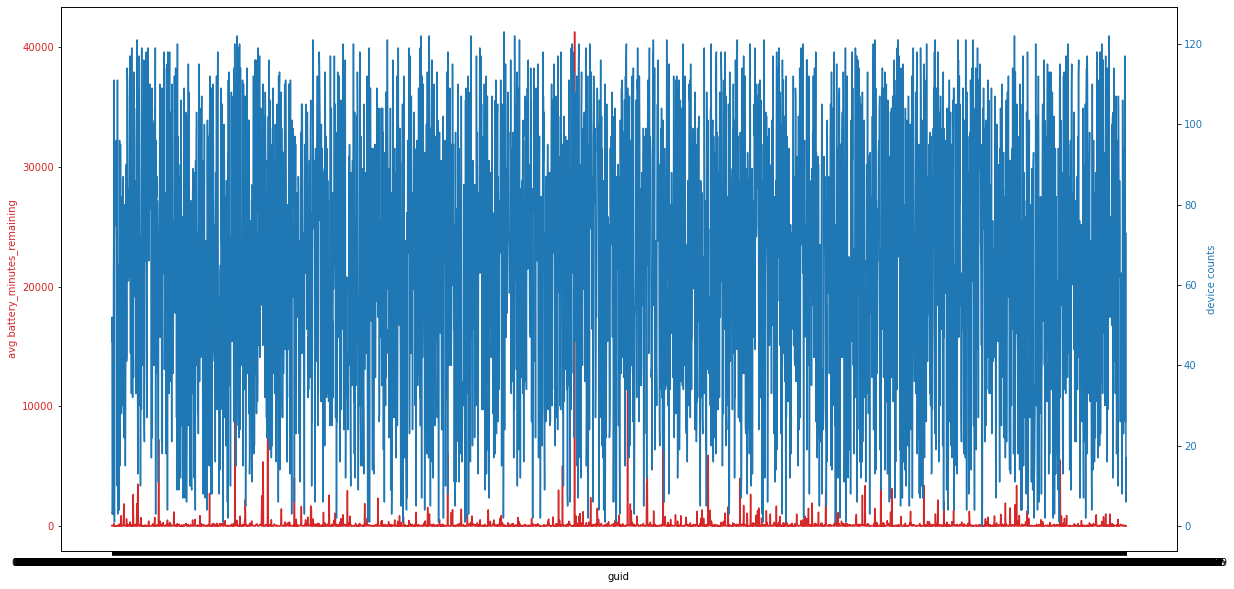

In [14]:
data1 = battery_event.groupby(['guid']).battery_minutes_remaining.mean()
data1 = data1.loc[data1>0]

data2 = device_use.set_index('guid').loc[set(battery_event.guid)].reset_index().groupby(['guid']).name.count().sort_index()
data2 = data2.loc[data1.index]


fig, ax1 = plt.subplots(figsize=(20, 10))
color = 'tab:red'
ax1.set_xlabel('guid')
ax1.set_ylabel('avg battery_minutes_remaining', color=color)
ax1.plot(data1.index, data1, color=color) 
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('device counts', color=color)
ax2.plot(data1.index, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()


In [15]:
np.corrcoef(data1, data2)

array([[1.        , 0.02183561],
       [0.02183561, 1.        ]])

## - process Dataset

## Second guessing: ` battery minutes remaining ` is related with ` number of process `

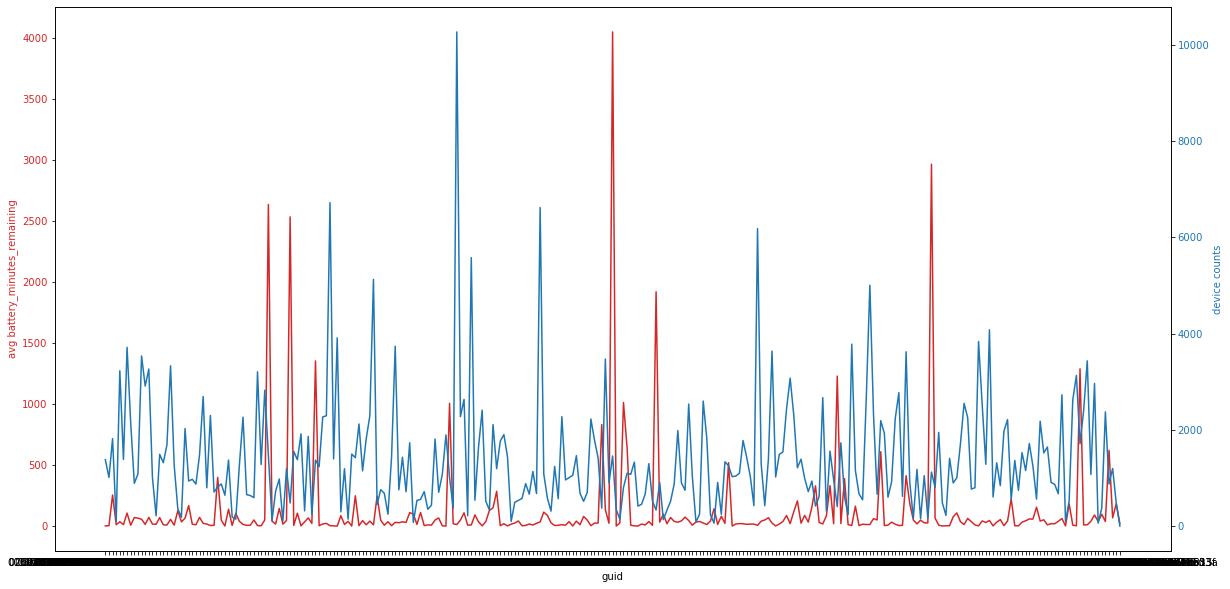

In [16]:
data1 = battery_event.groupby(['guid']).battery_minutes_remaining.mean()
data1 = data1.loc[data1>0]

needed = set(battery_event.guid).intersection(set(process.guid))
num_proc = process.set_index('guid').loc[needed].reset_index().groupby(['guid']).proc_name.count().sort_index()

data1 = data1.loc[set(num_proc.index).intersection(data1.index)]
num_proc = num_proc.loc[data1.index]


fig, ax1 = plt.subplots(figsize=(20, 10))
color = 'tab:red'
ax1.set_xlabel('guid')
ax1.set_ylabel('avg battery_minutes_remaining', color=color)
ax1.plot(data1.index, data1, color=color) 
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('device counts', color=color)
ax2.plot(data1.index, num_proc, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()


In [17]:
np.corrcoef(data1, num_proc)

array([[ 1.        , -0.06392438],
       [-0.06392438,  1.        ]])

## Third guessing: ` battery minutes remaining ` is related with ` Average Page Faults `

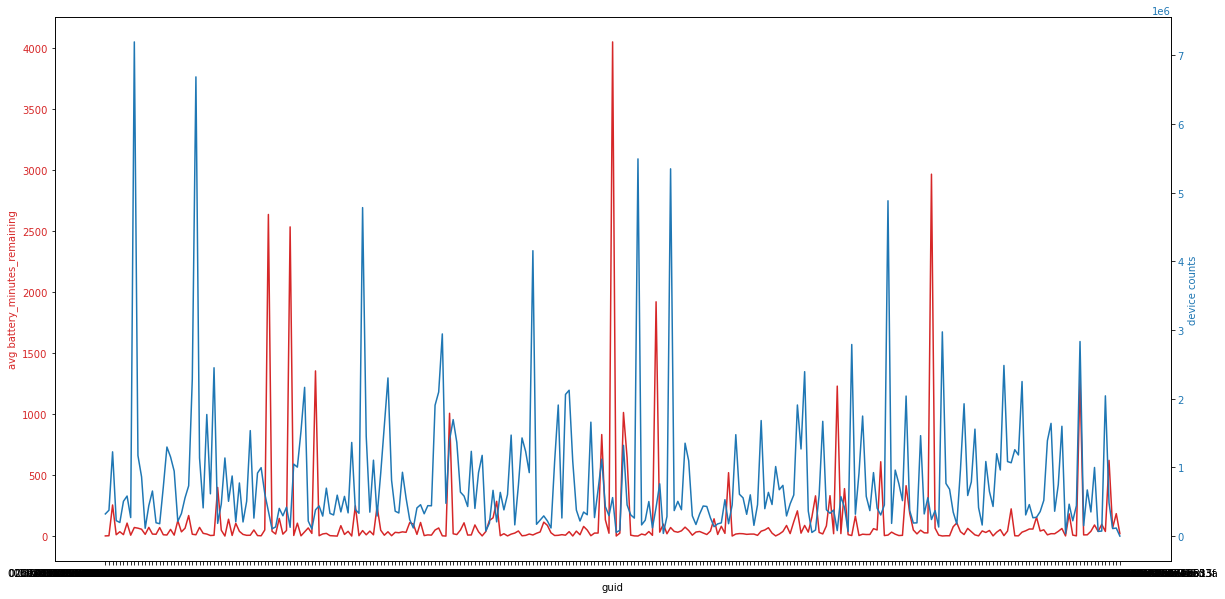

In [18]:
data1 = battery_event.groupby(['guid']).battery_minutes_remaining.mean()
data1 = data1.loc[data1>0]

needed = set(battery_event.guid).intersection(set(process.guid))
page_faults = process.set_index('guid').loc[needed].reset_index().groupby(['guid']).page_faults.mean().sort_index()

data1 = data1.loc[set(page_faults.index).intersection(data1.index)]
page_faults = page_faults.loc[data1.index]


fig, ax1 = plt.subplots(figsize=(20, 10))
color = 'tab:red'
ax1.set_xlabel('guid')
ax1.set_ylabel('avg battery_minutes_remaining', color=color)
ax1.plot(data1.index, data1, color=color) 
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('device counts', color=color)
ax2.plot(data1.index, page_faults, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

In [19]:
np.corrcoef(data1, page_faults)

array([[ 1.        , -0.06139869],
       [-0.06139869,  1.        ]])

## Fourth guessing: ` battery minutes remaining ` is related with ` Average Memory`

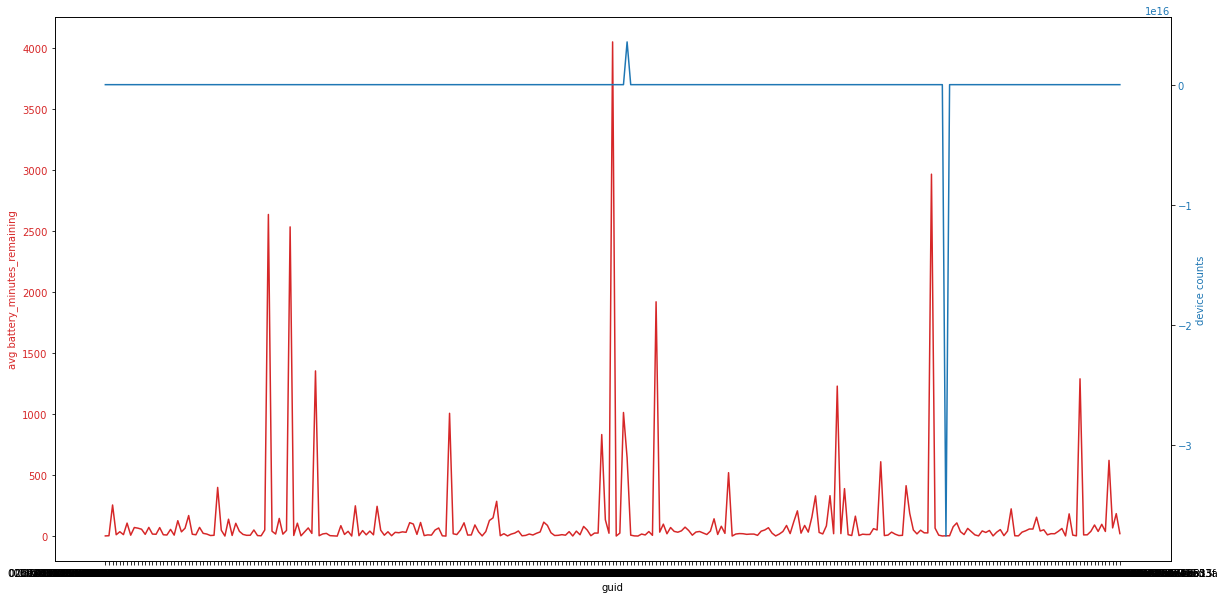

In [20]:
data1 = battery_event.groupby(['guid']).battery_minutes_remaining.mean()
data1 = data1.loc[data1>0]

needed = set(battery_event.guid).intersection(set(process.guid))
data2 = process.set_index('guid').loc[needed].reset_index().groupby(['guid']).avg_memory.mean().sort_index()

data1 = data1.loc[set(data2.index).intersection(data1.index)]
data2 = data2.loc[data1.index]


fig, ax1 = plt.subplots(figsize=(20, 10))
color = 'tab:red'
ax1.set_xlabel('guid')
ax1.set_ylabel('avg battery_minutes_remaining', color=color)
ax1.plot(data1.index, data1, color=color) 
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('device counts', color=color)
ax2.plot(data1.index, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

In [21]:
np.corrcoef(data1, data2)

array([[1.        , 0.02491612],
       [0.02491612, 1.        ]])

## Fifth guessing: ` battery minutes remaining ` is related with `cpu_user_sec	` + `cpu_kernel_sec	`

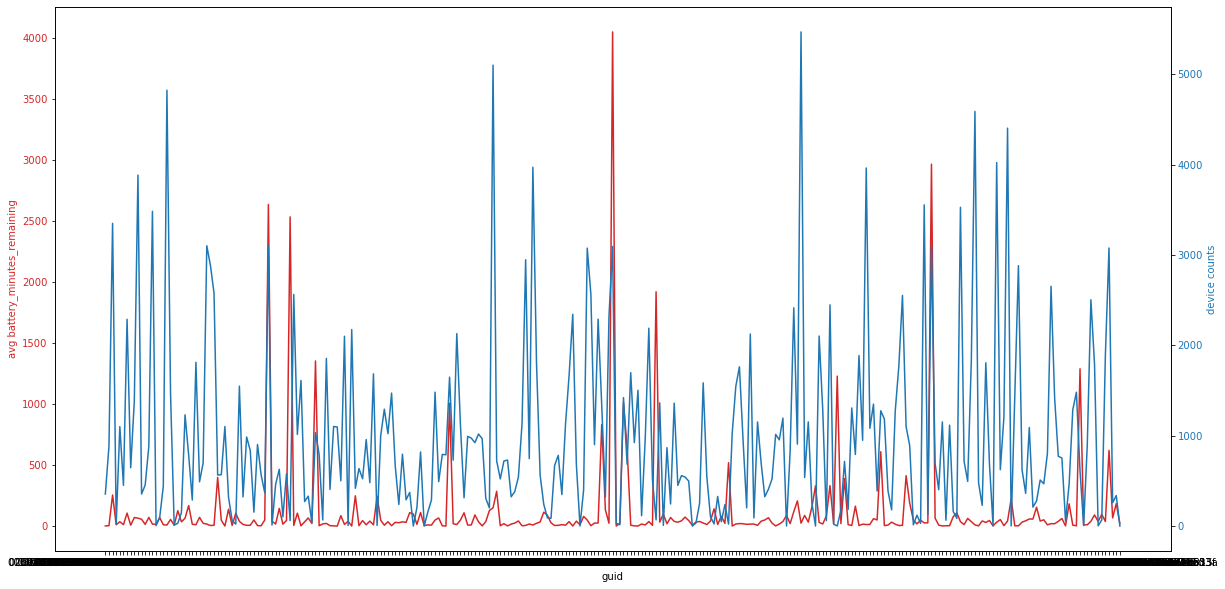

In [81]:
data1 = battery_event.groupby(['guid']).battery_minutes_remaining.mean()
data1 = data1.loc[data1>0]

needed = set(battery_event.guid).intersection(set(process.guid))
process['cpu_sec']= process['cpu_user_sec']+process['cpu_kernel_sec']
data2 = process.set_index('guid').loc[needed].reset_index().groupby(['guid']).cpu_sec.mean().sort_index()

data1 = data1.loc[set(data2.index).intersection(data1.index)]
cpu_sec = data2.loc[data1.index]


fig, ax1 = plt.subplots(figsize=(20, 10))
color = 'tab:red'
ax1.set_xlabel('guid')
ax1.set_ylabel('avg battery_minutes_remaining', color=color)
ax1.plot(data1.index, data1, color=color) 
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('device counts', color=color)
ax2.plot(data1.index, cpu_sec, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

In [82]:
np.corrcoef(data1, cpu_sec)

array([[1.        , 0.12093315],
       [0.12093315, 1.        ]])

## - Battery_info Dataset

## Sixth guessing: ` battery minutes remaining ` is related with `full_charge_capacity	`

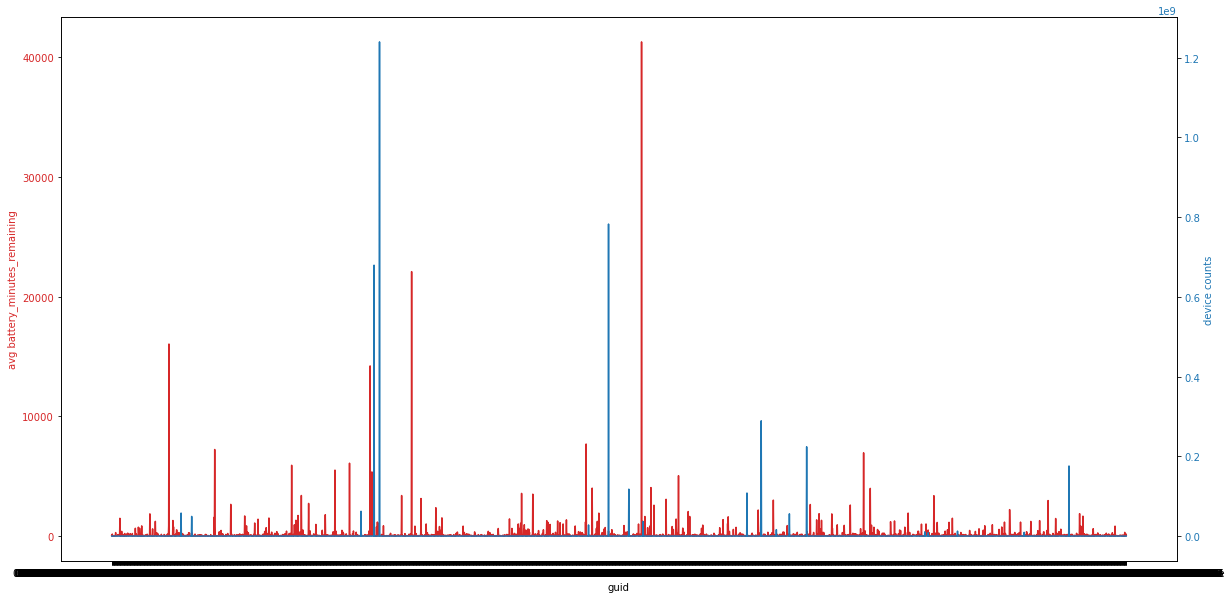

In [24]:
data1 = battery_event.groupby(['guid']).battery_minutes_remaining.mean()
data1 = data1.loc[data1>0]
needed = set(battery_event.guid).intersection(set(battery_info.guid))
data2 = battery_info.set_index('guid').loc[needed].reset_index().groupby(['guid']).full_charge_capacity.mean().sort_index()
data1 = data1.loc[set(data2.index).intersection(data1.index)]
capacity = data2.loc[data1.index]

fig, ax1 = plt.subplots(figsize=(20, 10))
color = 'tab:red'
ax1.set_xlabel('guid')
ax1.set_ylabel('avg battery_minutes_remaining', color=color)
ax1.plot(data1.index, data1, color=color) 
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('device counts', color=color)
ax2.plot(data1.index, capacity, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

In [25]:
np.corrcoef(data1, capacity)

array([[ 1.        , -0.00202691],
       [-0.00202691,  1.        ]])

## - hw_metric_histo Dataset

## 7th guessing: ` battery minutes remaining ` is related with `cpu_percent`

In [26]:
cpu_info = cpu.groupby(['guid','name'])['mean'].mean().reset_index(level=[0,1])
cpu_percent = cpu_info.loc[cpu_info.name == 'HW::CORE:C0:PERCENT:']
cpu_centi_temp = cpu_info.loc[cpu_info.name == 'HW::CORE:TEMPERATURE:CENTIGRADE:']

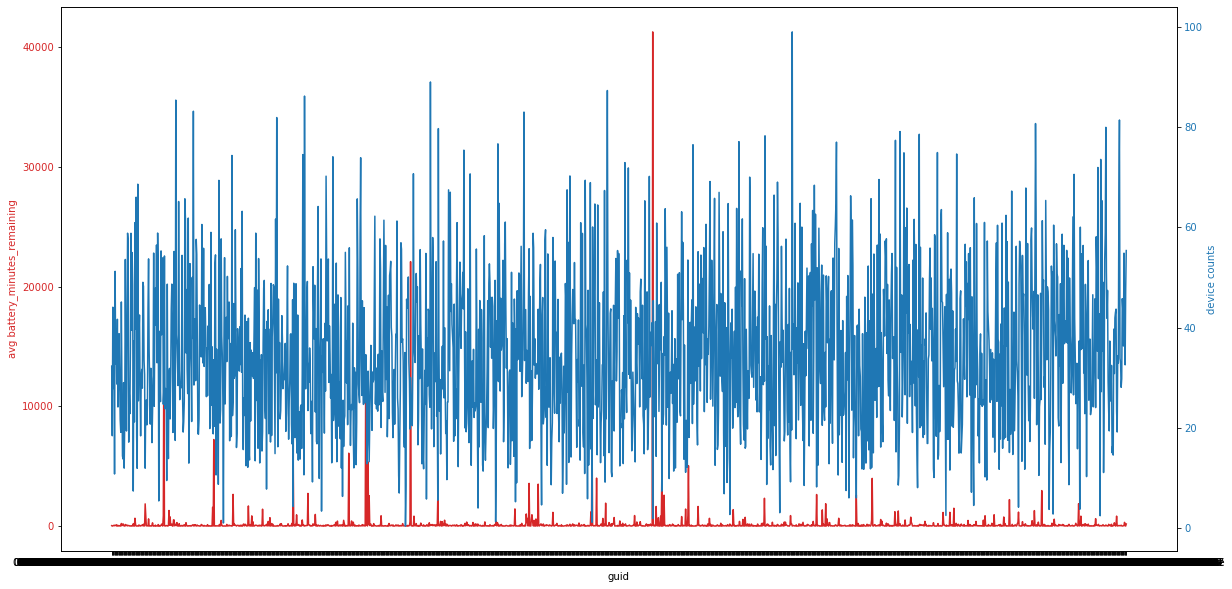

In [27]:
data1 = battery_event.groupby(['guid']).battery_minutes_remaining.mean()
data1 = data1.loc[data1>0]

needed = set(data1.index).intersection(set(cpu_percent.guid))
cpu_percent = cpu_percent.set_index('guid').loc[needed]['mean']

data1 = data1.loc[set(cpu_percent.index).intersection(data1.index)]
cpu_percent = cpu_percent.loc[data1.index]

fig, ax1 = plt.subplots(figsize=(20, 10))
color = 'tab:red'
ax1.set_xlabel('guid')
ax1.set_ylabel('avg battery_minutes_remaining', color=color)
ax1.plot(data1.index, data1, color=color) 
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('device counts', color=color)
ax2.plot(data1.index, cpu_percent, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

In [28]:
np.corrcoef(data1, cpu_percent)

array([[ 1.        , -0.08184048],
       [-0.08184048,  1.        ]])

## 8th guessing: ` battery minutes remaining ` is related with `cpu_temperature`

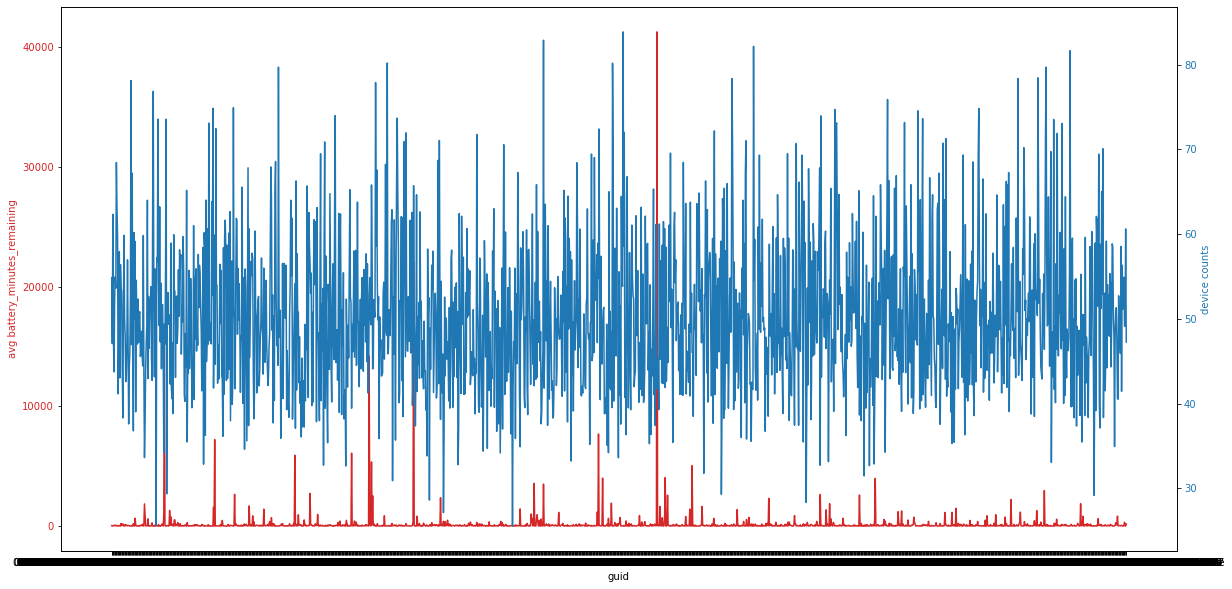

In [29]:
data1 = battery_event.groupby(['guid']).battery_minutes_remaining.mean()
data1 = data1.loc[data1>0]

needed = set(data1.index).intersection(set(cpu_centi_temp.guid))
cpu_temp = cpu_centi_temp.set_index('guid').loc[needed]['mean']

data1 = data1.loc[set(cpu_temp.index).intersection(data1.index)]
cpu_temp = cpu_temp.loc[data1.index]

fig, ax1 = plt.subplots(figsize=(20, 10))
color = 'tab:red'
ax1.set_xlabel('guid')
ax1.set_ylabel('avg battery_minutes_remaining', color=color)
ax1.plot(data1.index, data1, color=color) 
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('device counts', color=color)
ax2.plot(data1.index, cpu_temp, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

In [30]:
np.corrcoef(data1, cpu_temp)

array([[ 1.        , -0.01447771],
       [-0.01447771,  1.        ]])

# Hypothesis Testing

<b>Null Hypothesis</b>: The observed mean absolute error is similar to the mean absolute errors generated from the general dataset. 

<b>Alternative Hypothesis</b>: The observed mean absolute error is less than the mean absolute errors generated from the general dataset.

To test our hypothesis testing, we will get the mean squared error of each of our models and compare these numbers to the simulated distribution and check if the p-value is within our threshold of 0.05.

In [217]:
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# helper methods 

# calculates the mean absolute error of the given model
def mae(model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    reg = model.fit(X_train, y_train)
    train_error = mean_absolute_error(y_train, reg.predict(X_train))
    test_error = mean_absolute_error(y_test, reg.predict(X_test))
    
    return train_error, test_error

# run a simulation to see how different the observed mean absolute error is from the simulation 
def simulation(model):
    errors = []
    for _ in range(1000):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        reg = model.fit(X_train, y_train)
        errors.append(mean_absolute_error(y_test, reg.predict(X_test)))
        
    return errors

# the features are number of processes, page faults, capacity, cpu percentage, and cpu temperature 
X = pd.concat([num_proc, page_faults, capacity, cpu_percent, cpu_temp], axis = 1).dropna()
y = battery_event[['guid', 'battery_minutes_remaining']][battery_event.guid.isin(X.index)].groupby('guid')['battery_minutes_remaining'].apply(lambda x: (x!=-1).mean())



In [182]:
# for our baseline model, we will use linear regression for calculating mean absolute error 
linear_train, linear_test = mae(LinearRegression())
linear_train, dt_test

(0.1992089576364057, 0.32750764535115645)

(array([1.23439489, 0.06799633, 0.05579186, 0.05056137, 0.04358739,
        0.04358739, 0.03312642, 0.0383569 , 0.03138292, 0.02266544,
        0.01743496, 0.01569146, 0.02440894, 0.01394796, 0.01220447,
        0.00697398, 0.00697398, 0.00697398, 0.00523049, 0.00348699,
        0.00523049, 0.0017435 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.0017435 ]),
 array([ 0.15967894,  0.73323932,  1.3067997 ,  1.88036008,  2.45392046,
         3.02748084,  3.60104122,  4.1746016 ,  4.74816198,  5.32172235,
         5.89528273,  6.46884311,  7.04240349,  7.61596387,  8.18952425,
         8.76308463,  9.33664501,  9.91020539, 10.48376577, 11.05732615,
        11.63088653, 12.20444691, 12.77800729, 13.35156767, 13.92512804,
        14.49868842, 15.0722488 , 15.64580918, 16.21936956, 16.79292994,
        17.36649032]),
 <a list of 30 Patch objects>)

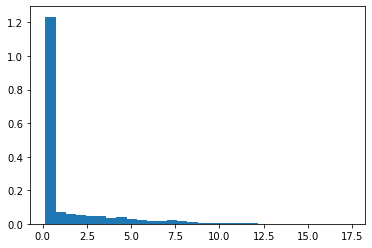

In [202]:
# next, to run a hypothesis testing, we will bootstrap 1000 times to simulate a distribution 
# and see how different the observed mean absolute error is from the simulation
linear_errors = simulation(LinearRegression())

plt.hist(linear_errors, density=True, bins=30)

In [214]:
p_val = (linear_errors <= linear_train).mean()
p_val 

# with a p-value of 0.276, we fail to reject the null hypothesis
# thus, we will consider another model for our hypothesis testing 

0.276

# Improving Model 

In [204]:
# to improve our baseline model, we will consider SVM for calculating mean absolute error 
svm_train, svm_test = mae(svm.SVR())
svm_train, svm_test

(0.18540187636064667, 0.23421616287793817)

(array([ 0.31197107,  0.        ,  1.55985535,  2.49576855,  1.55985535,
         4.67956604,  6.86336352,  9.35913208,  9.35913208, 11.23095849,
        10.91898742, 16.84643774, 22.77388805, 23.70980126, 24.95768554,
        27.76542516, 27.76542516, 23.70980126, 21.21403271, 17.47037988,
        12.79081384, 12.79081384,  6.55139245,  5.92745032,  3.11971069,
         2.18379748,  1.55985535,  1.24788428,  0.31197107,  0.93591321]),
 array([0.15331415, 0.15651957, 0.159725  , 0.16293043, 0.16613585,
        0.16934128, 0.1725467 , 0.17575213, 0.17895755, 0.18216298,
        0.1853684 , 0.18857383, 0.19177925, 0.19498468, 0.19819011,
        0.20139553, 0.20460096, 0.20780638, 0.21101181, 0.21421723,
        0.21742266, 0.22062808, 0.22383351, 0.22703893, 0.23024436,
        0.23344979, 0.23665521, 0.23986064, 0.24306606, 0.24627149,
        0.24947691]),
 <a list of 30 Patch objects>)

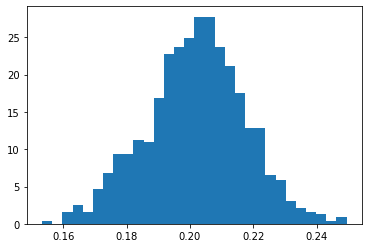

In [205]:
# next, to run a hypothesis testing, we will bootstrap 1000 times to simulate a distribution 
# and see how different the observed mean absolute error is from the simulation
svm_errors = simulation(svm.SVR())
    
plt.hist(svm_errors, density=True, bins=30)

In [207]:
p_val = (svm_errors <= svm_train).mean()
p_val

# with a p-value of 0.152, we fail to reject the null hypothesis
# thus, we will need to consider a better model 

0.152

In [211]:
# This time, we will use decision tree regressor to calculate mean absolute error 
dt_train, dt_test = mae(DecisionTreeRegressor(random_state=0))
dt_train, dt_test

(1.5274384551368124e-06, 0.3092834478762173)

(array([ 0.54464608,  0.90774347,  1.45238955,  1.27084086,  2.36013302,
         3.99407127,  5.62800952,  6.71730168,  9.0774347 ,  9.62208079,
        14.16079814, 15.06854161, 16.70247985, 16.52093116, 15.61318769,
        12.1637625 , 11.80066511,  7.62504515,  8.35123993,  6.35420429,
         5.44646082,  4.53871735,  2.54168172,  0.72619478,  0.72619478,
         0.18154869,  0.54464608,  0.36309739,  0.18154869,  0.36309739]),
 array([0.19193976, 0.19744793, 0.20295609, 0.20846426, 0.21397242,
        0.21948058, 0.22498875, 0.23049691, 0.23600508, 0.24151324,
        0.24702141, 0.25252957, 0.25803773, 0.2635459 , 0.26905406,
        0.27456223, 0.28007039, 0.28557855, 0.29108672, 0.29659488,
        0.30210305, 0.30761121, 0.31311937, 0.31862754, 0.3241357 ,
        0.32964387, 0.33515203, 0.3406602 , 0.34616836, 0.35167652,
        0.35718469]),
 <a list of 30 Patch objects>)

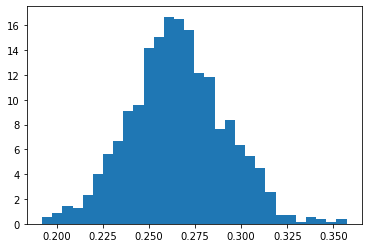

In [212]:
# next, to run a hypothesis testing, we will bootstrap 1000 times to simulate a distribution 
# and see how different the observed mean absolute error is from the simulation
dt_errors = simulation(DecisionTreeRegressor(random_state=0))
    
plt.hist(dt_errors, density=True, bins=30)

In [215]:
p_val = (dt_errors <= dt_train).mean()
p_val

# with a p-value of 0, we reject the null hypothesis

0.0

# Overfitting 

In [245]:
# though we got a p-value of 0 for decision tree regressor, from the large difference in mean absolute errors 
# between train data and test data, 1.5274384551368124e-06 and 0.3092834478762173 respectively, we can clearly 
# see that this model suffers from overfitting 

# let's see if removing features would reduce the difference between the two mean absolute errors 
# first, let's remove number of processes 
X = pd.concat([page_faults, capacity, cpu_percent, cpu_temp], axis = 1).dropna()

dt_train, dt_test = mae(DecisionTreeRegressor(random_state=0))
print(dt_train, dt_test)

# next, let's remove page faults
X = pd.concat([num_proc, capacity, cpu_percent, cpu_temp], axis = 1).dropna()

dt_train, dt_test = mae(DecisionTreeRegressor(random_state=0))
print(dt_train, dt_test)

# let's remove capacity
X = pd.concat([num_proc, page_faults, cpu_percent, cpu_temp], axis = 1).dropna()

dt_train, dt_test = mae(DecisionTreeRegressor(random_state=0))
print(dt_train, dt_test)

# let's remove cpu percentage
X = pd.concat([num_proc, page_faults, capacity, cpu_temp], axis = 1).dropna()

dt_train, dt_test = mae(DecisionTreeRegressor(random_state=0))
print(dt_train, dt_test)

# unfortunately, we can see that removing features does not really reduce the issue of overfitting since 
# the difference between the 2 mean absolute errors is still pretty large 
# in future works, we will need to think about how to tackle this issue of overfitting 

1.0329127312690494e-06 0.2554975640945912
9.086769172913107e-06 0.2626973681404361
4.945257238677628e-07 0.24011948478298412
7.30407254694071e-06 0.25866816429588557
